In [1]:
"""https://arxiv.org/pdf/1708.02043.pdf"""

'https://arxiv.org/pdf/1708.02043.pdf'

In [0]:
#download Flickr8k dataset and glove.6B.50d
!bash download_data.sh

100% 1.09G/1.09G [00:10<00:00, 103MB/s]
100% 1.09G/1.09G [00:10<00:00, 108MB/s]
 99% 67.0M/67.7M [00:00<00:00, 110MB/s]
100% 67.7M/67.7M [00:00<00:00, 138MB/s]


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [0]:
allimage = os.listdir('Images')
data = pd.read_csv('captions.txt', sep='\t',header=None, names= ['image','caption'])
data.image = data.image.apply( lambda x: x.split('jpg')[0]+'jpg' )
data['avail'] = data.image.apply( lambda x: x in allimage )
data = data[ data.avail==True ]
data = data.dropna()
print(data.shape)
data.head()

(40455, 3)


,image,caption,avail
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,True
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,True
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,True
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,True
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,True


In [0]:
import gc
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
word_counter = defaultdict(int)

table = str.maketrans('', '', string.punctuation,)
def preprocesCaption( caption):
  caption = caption.lower() #to lower case
  caption = caption.translate(table) #remove punctuations
  caption = caption.split() # convert to words
  caption = [ w for w in caption if len(w) > 1 ] #remove dangling 'a' and 's'
  caption = [ w for w in caption if w.isalpha()  ] #keep only words with alphabets
  caption = [ lemmatizer.lemmatize(w) for w in caption ]
  for w in caption: word_counter[w]+=1
  return ' '.join(caption)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


100%|██████████| 8091/8091 [00:30<00:00, 268.74it/s]


8091 1748


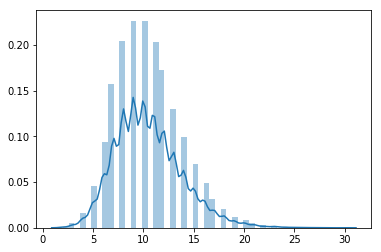

In [0]:
from collections import defaultdict

words = set()
words.update( ('<S>','</S>') )
mx = []

images = defaultdict(list)
for img in tqdm(data.image.unique()):
    for comment in data[data.image == img ].caption.values:
        caption = preprocesCaption(comment)
        caption = [ w for w in caption.split() if word_counter[w]>=10 ]  #taking words whose count atleast 10
        words.update( caption )
        mx.append( len(caption)+2 )
        images[img].append( '<S> '+" ".join(caption)+' </S>' )
        
print(len(images), len(words))
del data; gc.collect()
sns.distplot(mx)


In [0]:
ind_to_word={}
word_to_ind = {}
for i,w in enumerate(words):
  ind_to_word[i+1] = w
  word_to_ind[w] = i+1

In [0]:
from keras.preprocessing.sequence import pad_sequences
images_caption = defaultdict(list)
MAX_SEQ_LEN = 17
VOCAB_SIZE = len(words)+1

for img in images.keys():
    arr = []
    for caption in images[img]:
        arr.append( [ word_to_ind.get(word) for word in caption.split() ] )
    images_caption[img] = arr

Using TensorFlow backend.


In [0]:
embeddings = np.zeros(shape=(VOCAB_SIZE,50))
with open('glove.6B.50d.txt','r') as glov:
    for line in glov.readlines():
        line = line.split()
        if line[0] in words:
            embeddings[word_to_ind[line[0]]] = list(map(float,line[1:]))
embeddings.shape

(1749, 50)

In [0]:
import random
data = []
for key in images_caption.keys():
    for caption in images_caption[key]:
        data.append( (key, caption) )
del images_caption; gc.collect()
data[:2]

[('1000268201_693b08cb0e.jpg', [1270, 1620]),
 ('1000268201_693b08cb0e.jpg', [1270, 1620])]

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
Xtext, Ximage, ytext = [],[],[]
for image,text in tqdm(data):
    for i in range(1,len(text)):
        in_text, out_text = text[:i], text[i]
        in_text = pad_sequences([in_text],maxlen=MAX_SEQ_LEN,padding='pre').flatten()
        out_text = to_categorical(out_text,num_classes = VOCAB_SIZE)
        Xtext.append(in_text)
        Ximage.append(image)
        ytext.append(out_text)
Xtext  = np.array(Xtext)
Ximage = np.array(Ximage)
ytext  = np.array(ytext)
print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))

100%|██████████| 40455/40455 [00:17<00:00, 2353.26it/s]


 (383850, 17) (383850,) (383850, 1749)


In [0]:
from sklearn.model_selection import train_test_split
VALIDATION_SPLIT = 0.2
num_rec = int(len(ytext)*VALIDATION_SPLIT)
def split(dt,rec):
    return dt[:-1*rec],dt[-1*rec:]

Ttext, Vtext = split(Xtext,num_rec)
del Xtext; gc.collect()
Timage, Vimage = split(Ximage,num_rec)
del Ximage; gc.collect()
Ty,Vy = split(ytext,num_rec)
del ytext; gc.collect()
len(Ttext),len(Vtext)

(307080, 76770)

In [0]:
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.models import Model

IMG_DIM = (224,224,3)
vgg19 = VGG19(weights='imagenet',include_top=True, input_shape=IMG_DIM)
vgg19.layers.pop()
vggModel = Model( vgg19.input,vgg19.layers[-1].output)
imagemap = {}

def getImageFeature(path):
    temp = preprocess_input( img_to_array( load_img( os.path.join(path), target_size=IMG_DIM[:2] )) )
    return vggModel.predict(np.expand_dims(temp,axis=0))[0]

for img in tqdm(list(set(np.append(Timage,Vimage)))):  
    imagemap[img] = getImageFeature('Images/'+img)

W0823 07:19:44.873922 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 07:19:44.920810 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 07:19:44.928002 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0823 07:19:44.977153 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



574717952/574710816 [==============================] - 16s 0us/step


W0823 07:20:02.711706 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 07:20:02.713465 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

100%|██████████| 8091/8091 [05:16<00:00, 25.58it/s]


In [0]:
Timages = np.array([ imagemap[img] for img in Timage ])
del Timage; gc.collect()
Vimages = np.array([ imagemap[img] for img in Vimage ])
del Vimage, imagemap; gc.collect()
Timages.shape,Vimages.shape

((307080, 4096), (76770, 4096))

In [0]:
from keras.layers import LSTM, Dense, Input, Embedding, add
from keras.models import Model
from keras.initializers import Constant

EMBEDDING_DIM = 50

inp_img = Input( shape=(4096,) ) 
feature_img = Dense(256,activation='relu',name="ImageFeature")(inp_img)

input_txt = Input(shape=(MAX_SEQ_LEN,))
ftxt = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, 
                 embeddings_initializer=Constant(embeddings),
                 trainable=False)(input_txt)
ftxt = LSTM(256,name="CaptionFeature")(ftxt)

decoder = add([ftxt,feature_img])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(VOCAB_SIZE,activation='softmax')(decoder)

model = Model(inputs=[inp_img, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

W0823 07:25:27.832578 139887796373376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0823 07:25:27.901221 139887796373376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 17)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 17, 50)       87450       input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          314368      embedding_1[0][0]                
__________________________________________________________________________________________________
ImageFeatu

In [0]:
hist = model.fit([Timages,Ttext],Ty,
                 epochs=4, verbose=1,
                 batch_size=64,
                 validation_data=([Vimages,Vtext],Vy))

Train on 307080 samples, validate on 76770 samples
Epoch 1/4
307080/307080 [==============================] - 256s 834us/step - loss: 3.7704 - val_loss: 3.6923
Epoch 2/4
307080/307080 [==============================] - 257s 837us/step - loss: 3.1675 - val_loss: 3.5784
Epoch 3/4
307080/307080 [==============================] - 255s 832us/step - loss: 2.9638 - val_loss: 3.5517
Epoch 4/4
307080/307080 [==============================] - 257s 836us/step - loss: 2.8333 - val_loss: 3.5928


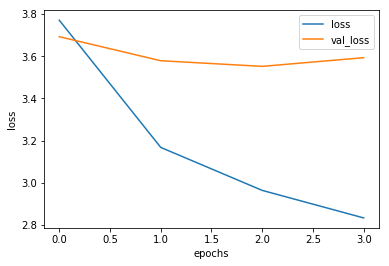

In [0]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
!bash download_dev.sh

mkdir: cannot create directory ‘dev’: File exists


In [0]:
def getNextWords(image,in_text,n=1):
    sequence=  [word_to_ind[w] for w in in_text.split()]
    sequence = pad_sequences([sequence],MAX_SEQ_LEN)
    yhat = model.predict([image,sequence],verbose=0)
    topn = yhat.argsort()[0][-1*n:][::-1]
    probs = yhat[0][topn]
    return [ (ind_to_word[i],p) for i,p in zip(topn,probs) ]

In [0]:
def predict_caption(image_path):
    image = np.expand_dims(getImageFeature(image_path),axis=0)
    in_text = '<S>'
    while i in range(MAX_SEQ_LEN):
        nw = getNextWords(image,in_text,n=1)[0][0]
        in_text += ' '+nw
        if nw == "</S>":
            break
    return in_text
predict_caption('dev/dev1.jpeg')

'<S> man in life jacket is paddling through water </S>'

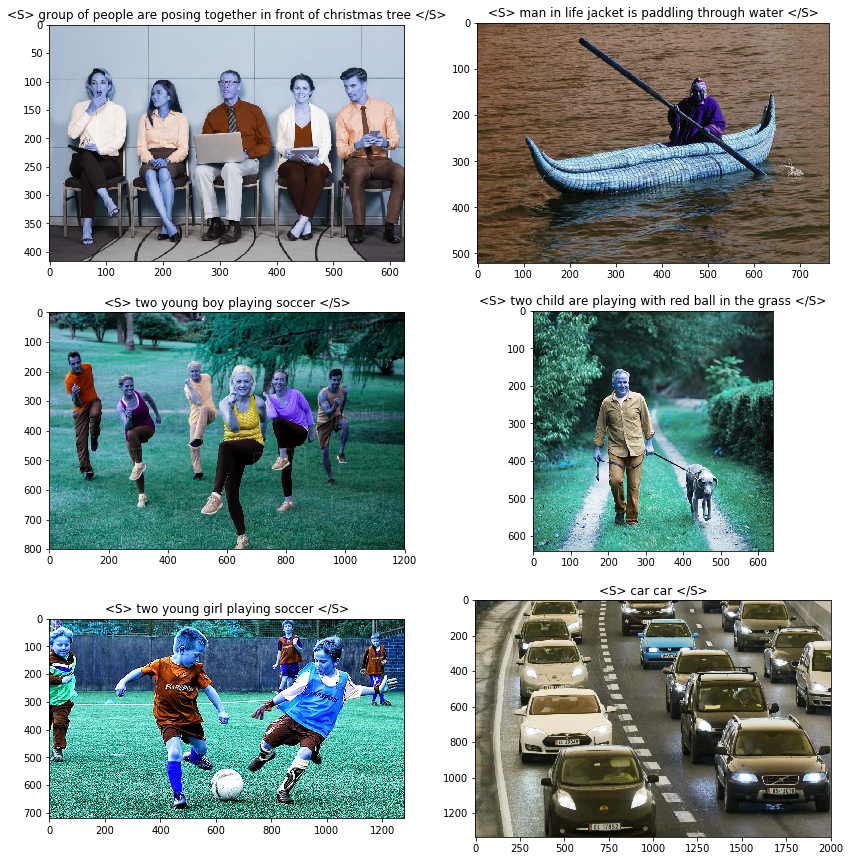

In [0]:
import glob
import cv2
allimgs = glob.glob('dev/*')
n = len(allimgs)
fig,ax = plt.subplots(nrows=(n//2)+n%2,ncols=2,figsize=(14,15))
i=0
for img in allimgs:
  ax[i//2][i%2].imshow(cv2.imread(img))
  ax[i//2][i%2].set_title(predict_caption(img))
  i+=1

In [0]:
allimgs

['dev/dev5.jpeg',
 'dev/dev1.jpeg',
 'dev/dev3.jpeg',
 'dev/dev2.jpeg',
 'dev/dev4.jpeg',
 'dev/dev6.jpeg']

In [0]:
def beam_search_caption(image_path,beam_length=2,topn=5):
    image = np.expand_dims(getImageFeature(image_path),axis=0)
    beam = [ (1,'<S>') ]
    ans = []
    while len(beam)>0:
        cp,in_text = beam.pop(0)
        if len(in_text.split())>=MAX_SEQ_LEN:
            ans.append((cp,in_text))
            continue
        newwords  = getNextWords(image,in_text,n=beam_length)
        for nw,prob in newwords:
            if nw == "</S>":
                ans.append( (cp*prob,in_text+" "+nw) )
            else:
                beam.append( (cp*prob,in_text+" "+nw) )
    return [x[1] for x in sorted(ans,key=lambda x:x[0],reverse=True)[:topn]]
beam_search_caption('dev/dev1.jpeg')

['<S> man in life water </S>',
 '<S> two people are in water </S>',
 '<S> two people are in the water </S>',
 '<S> two people are rowing boat </S>',
 '<S> two people in life water </S>']

100%|██████████| 6/6 [12:04<00:00, 105.50s/it]


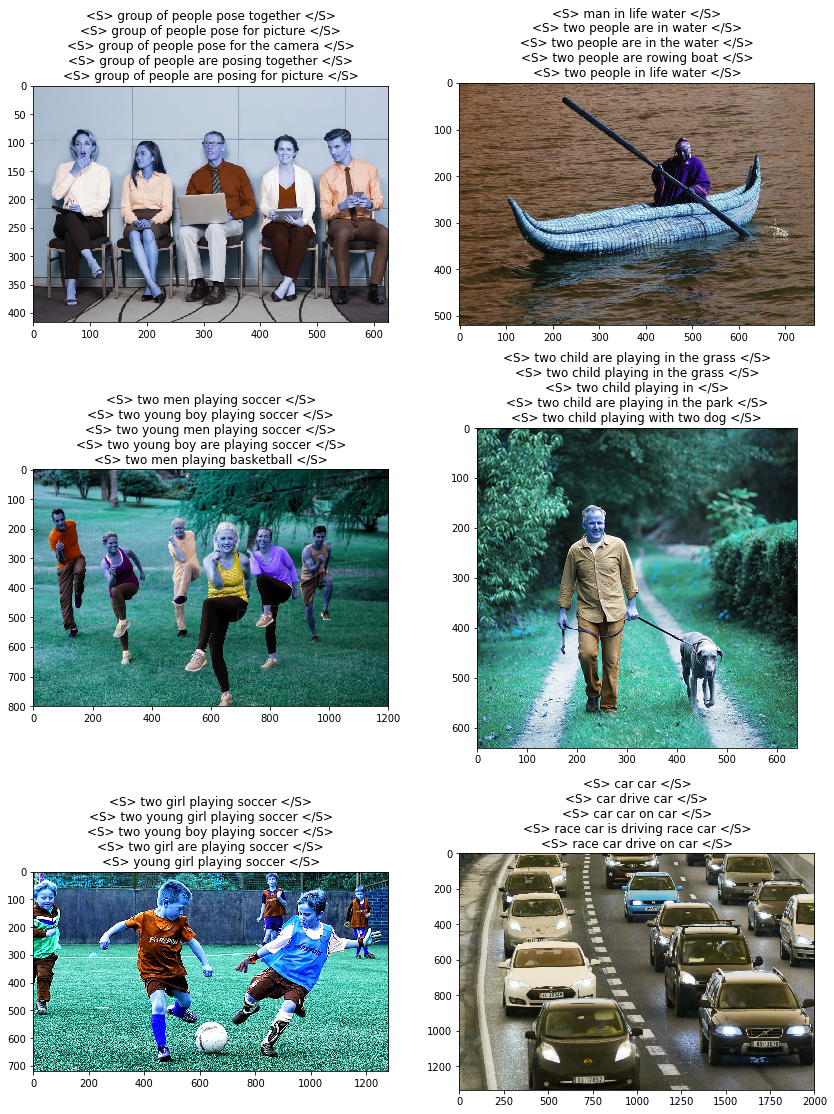

In [0]:
import glob
import cv2
allimgs = glob.glob('dev/*')
n = len(allimgs)
fig,ax = plt.subplots(nrows=(n//2)+n%2,ncols=2,figsize=(14,20))
i=0
for img in tqdm(allimgs):
    ax[i//2][i%2].imshow(cv2.imread(img))
    ax[i//2][i%2].set_title("\n".join(beam_search_caption(img,beam_length=2,topn=5)))
    i+=1